# Telecom

## Описание проекта

**Легенда проекта:**  
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.  
  
**Задача проекта** — обучить на этих данных модель для прогноза оттока клиентов.  

**Описание услуг**   
Оператор предоставляет два основных типа услуг:  
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).  

Также абонентам доступен ряд услуг:  
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);  
- Выделенная линия технической поддержки (Tech Support);  
- Облачное хранилище файлов для резервного копирования данных (Online Backup);  
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).  

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.  

**Описание данных**  
Данные хранятся в базе данных PostgreSQL.  
Она состоит из нескольких таблиц:  
- contract — информация о договорах;  
- personal — персональные данные клиентов;  
- internet — информация об интернет-услугах;  
- phone — информация об услугах телефонии.  

Информация о договорах актуальна на 1 февраля 2020.

**Цель обучения моделей**  
Значение метрики ROC-AUC должно быть выше 0.85.  

**Этапы выполнения проекта:**  
1. Выгрузка датасета из базы данныз SQL;  
2. Первичный анализ данный;  
3. Исследовательский анализ данных;  
4. Генерирование новых признаков;  
5. Подготовка данных к обучению;  
6. Обучение моделей;  
7. Тестирование модели;  
8. Общий вывод.

## Загрузка данных

Загрузим необходимые библиотеки

In [1]:
import json

import pandas as pd
import numpy as np
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import catboost as cb

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

d:\Programs\Anaconda\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('whitegrid',
              {'axes.facecolor': '0.85',
              'axes.edgecolor': '0.15',
              'grid.color': '0.7',
              'figure.facecolor': '0.9'})

Определим глобальные переменные

In [3]:
RANDOM_STATE = 230324
ALPHA = 0.05
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DB_CONFIG = "db_config.json"

Получим параметры подключения к базе данных

In [4]:
with open(DB_CONFIG, "r") as db_config:
    config = json.load(db_config)

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    config['user'],
    config['pwd'],
    config['host'],
    config['port'],
    config['db'],
)

Созадаим подключение

In [5]:
engine = create_engine(connection_string) 

Напишем тестовый запрос для проверки подключения

In [6]:
query = '''
SELECT *
FROM telecom.contract
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 
display(sample_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


Напишем запросы для выгрузки таблиц из базы данных

In [7]:
query_contract = '''
SELECT *
FROM telecom.contract;
'''
query_personal = '''
SELECT *
FROM telecom.personal;
'''
query_internet = '''
SELECT *
FROM telecom.internet;
'''
query_phone = '''
SELECT *
FROM telecom.phone;
'''

Выгрузим таблицы

In [8]:
df_contract = pd.read_sql_query(query_contract, con=engine) 
df_personal = pd.read_sql_query(query_personal, con=engine) 
df_internet = pd.read_sql_query(query_internet, con=engine) 
df_phone = pd.read_sql_query(query_phone, con=engine) 

In [9]:
df_contract.shape, df_personal.shape ,df_internet.shape , df_phone.shape

((7043, 8), (7043, 5), (5518, 8), (6362, 2))

## Исследовательский анализ и предобработка

Напишем функции для исследования таблиц

In [10]:
def max_number(data: pd.DataFrame, 
               column: str,
               bins:int = 10,
               span:list = None):
    
    if span:
        range_list = np.linspace(span[0], span[1], bins)
    else:
        range_list = np.linspace(data[column].min(), data[column].max(), bins)
    
    number = 0
    for i in  range(1, bins):
        now_number = data.loc[(data[column] >= range_list[i-1]) & 
                              (data[column] < range_list[i]), 
                              column].count()
        if now_number > number:
            number = now_number
    return number


def draw_gist(data: pd.DataFrame, 
              column: str, 
              bins:int = 10,
              figsize: list = [15, 8], 
              span: list = None,
              alpha: float = 0.8):
    
    title = column
    x_label = 'value of ' + title
    y_label = 'number of records'
    
    if data[column].dtype == 'O' or data[column].dtype == 'bool':
       
        display(data[column].describe())
        
        plt.figure(figsize=figsize)
        
        plt.bar(x = data[column].value_counts().index,
                height = data[column].value_counts().values)
        
        plt.legend(['value_count'])
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        plt.show()

    else:

        desc = data[column].describe()
        display(desc)

        if desc[6] + 1.5*(desc[6] - desc[4]) > desc[7]:
            q_interval_r = desc[7]
        else:
            q_interval_r = desc[6] + 1.5*(desc[6] - desc[4])

        if desc[4] - 1.5*(desc[6] - desc[4]) < desc[3]:
            q_interval_l = desc[3]
        else:
            q_interval_l = desc[4] - 1.5*(desc[6] - desc[4])
            
        if span:    
            data[column].plot(kind='hist', bins=bins, figsize=figsize, 
                              range=span, grid=True, alpha=0.8)
        else:
            data[column].plot(kind='hist', bins=bins, figsize=figsize, 
                              grid=True, alpha=0.8)
            
        max_numb = max_number(data, column, bins+1, span)

        plt.vlines(desc[4], 0, max_numb, color='y', linewidth=2, 
                  linestyle='--', alpha=0.7)
        plt.vlines(desc[5], 0, max_numb, color='r', linewidth=2, 
                  linestyle='--', alpha=0.7)
        plt.vlines(desc[6], 0, max_numb, color='y', linewidth=2, 
                  linestyle='--', alpha=0.7)
        plt.vlines(desc[1], 0, max_numb, color='g', linewidth=2, 
                  linestyle='--', alpha=0.7)

        plt.fill([desc[4], desc[4], desc[6], desc[6]], 
                 [0, max_numb, max_numb, 0],
                 'y', alpha=0.15)
    
        plt.vlines(q_interval_l, 0, max_numb, color='black', 
                   linewidth=1, linestyle='--', alpha=0.7)
        plt.vlines(q_interval_r, 0, max_numb, color='black', 
                   linewidth=1, linestyle='--', alpha=0.7)

        plt.legend(['value_count', 'Q1', 'Q2', 'Q3', 'mean', 'BOX',
                    'Q1-1.5IQR', 'Q3+1.5IQR'], loc='upper right')
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        plt.show()

In [11]:
def analyze_frame(data: pd.DataFrame, name: str, gist_column: list):
    print(f'Name tabel: {name}')
    print(f'Общее число записей в таблице: {data.shape[0]} \n')
    print('Info about columns \n')
    info_data = pd.DataFrame(columns=['data_type', 'non-null', 'null', 'percent_null', 'n_unique'])
    for column in data.columns:
        n_null = data[column].isna().sum()
        len_column = len(data[column])
        info_data.loc[column, :] = [data[column].dtype,
                                    len_column - n_null,
                                    n_null,
                                    n_null / len_column * 100,
                                    data[column].nunique()
                                    ] 
        
    display(info_data)
    print('\n')
    print(f'Number of duplicates: {data.duplicated().sum()} \n')
    
    print('Посмотрим на распределения признаков \n')
    for column in gist_column:
        draw_gist(data, column, 100, figsize=[8, 5])

Для начала выведем несколько строчек каждой таблицы

In [12]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [13]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
df_internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


В таблице df_internet неверно указаны названия колонок, это необходимо исправить для дальнейшего анализа

In [15]:
df_internet.columns = df_internet.loc[0, :].values
df_internet = df_internet.loc[1:, :].reset_index(drop=True)
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
df_phone.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


В таблице df_phone неверно указаны названия колонок, это необходимо исправить для дальнейшего анализа

In [17]:
df_phone.columns = df_phone.loc[0, :].values
df_phone = df_phone.loc[1:, :].reset_index(drop=True)
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Создадим словарь с названиями колонок каждой таблицы, для которых будем выводить диаграммы распределения 

In [18]:
column_for_gist = {
    'contract': ['Type', 
                 'PaperlessBilling',
                 'PaymentMethod', 
                 'MonthlyCharges', 
                 'TotalCharges'],
    'personal': ['gender', 
                 'SeniorCitizen', 
                 'Partner', 
                 'Dependents'],
    'internet': ['InternetService', 
                 'OnlineSecurity', 
                 'OnlineBackup',
                 'DeviceProtection', 
                 'TechSupport', 
                 'StreamingTV', 
                 'StreamingMovies'],
    'phone': ['MultipleLines']
}


Дальше применим функцию analyze_frame к каждой таблице

### df_contract

Name tabel: contract
Общее число записей в таблице: 7043 

Info about columns 



,data_type,non-null,null,percent_null,n_unique
customerID,object,7043,0,0.0,7043
BeginDate,object,7043,0,0.0,515
EndDate,object,1869,5174,73.463013,4
Type,object,7043,0,0.0,3
PaperlessBilling,object,7043,0,0.0,2
PaymentMethod,object,7043,0,0.0,4
MonthlyCharges,float64,7043,0,0.0,1585
TotalCharges,float64,7032,11,0.156183,6530




Number of duplicates: 0 

Посмотрим на распределения признаков 



count               7043
unique                 3
top       Month-to-month
freq                3875
Name: Type, dtype: object

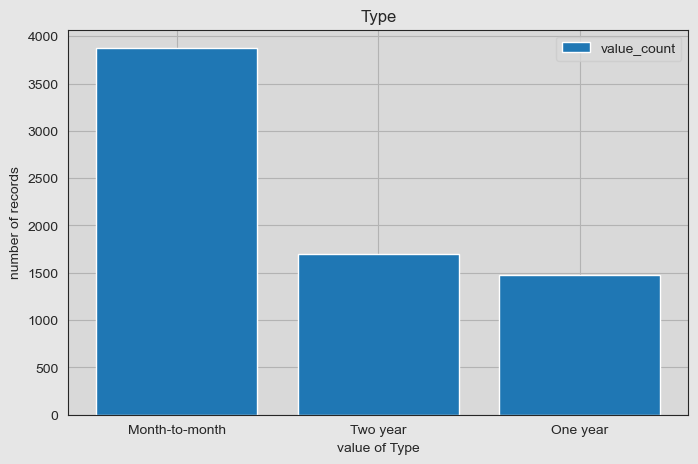

count     7043
unique       2
top        Yes
freq      4171
Name: PaperlessBilling, dtype: object

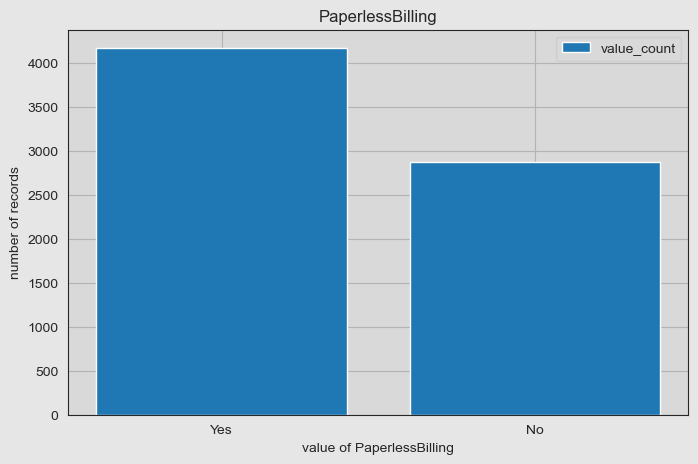

count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: PaymentMethod, dtype: object

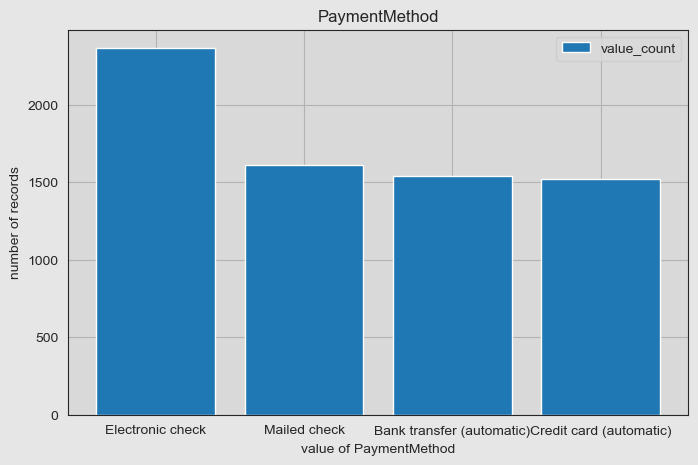

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

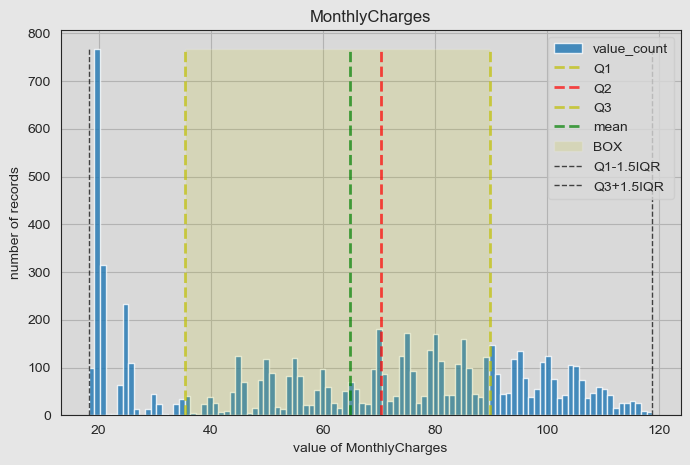

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

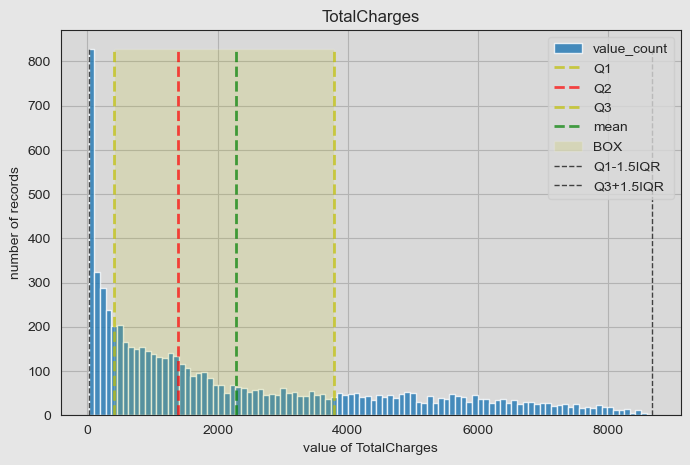

In [19]:
analyze_frame(df_contract, 'contract', column_for_gist['contract'])

Посмотрим, чем обусловлены пропуски в столбцу TotalCharges

In [20]:
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Пропуски заполним соответствующими значениями из столбца MonthlyCharges

In [21]:
nan_index = df_contract[df_contract['TotalCharges'].isna()].index
df_contract.loc[nan_index, 'TotalCharges'] = df_contract.loc[nan_index, 'MonthlyCharges'].values
df_contract.loc[nan_index, 'TotalCharges']

0       52.55
1       20.25
3       80.85
6       25.75
7       56.05
9       25.35
10      19.70
11      61.90
4408    19.85
5160    20.00
6839    73.35
Name: TotalCharges, dtype: float64

Приведем столбцы BeginDate и EndDate к типу данных datetime

In [22]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], 
                                          format='%Y-%m-%d')

df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], 
                                          format='%Y-%m-%d')

Выводы df_contract:  

- Всего записей в таблицк 7043;  
- Имеются пропуски в следующих столбцах:  
    - EndDate (пропуски обусловлены фактом действия контракта)
    - TotalCharges (пропуски обусловлены тем, что договор заключен на момент 01.02.2020, заполнили их соответствующими значениями из столбца MonthlyCharges);  
- Столбцы BeginDate и EndDate приведены к типу данных datetime
- Явных дубликатов не обнаружено;  
- В колонках с категориальным типом данных некорректных значений не обнаружено;  
- В колонках с числовым типом данных выбросов не обнаружено.

### df_personal

Name tabel: personal
Общее число записей в таблице: 7043 

Info about columns 



,data_type,non-null,null,percent_null,n_unique
customerID,object,7043,0,0.0,7043
gender,object,7043,0,0.0,2
SeniorCitizen,int64,7043,0,0.0,2
Partner,object,7043,0,0.0,2
Dependents,object,7043,0,0.0,2




Number of duplicates: 0 

Посмотрим на распределения признаков 



count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object

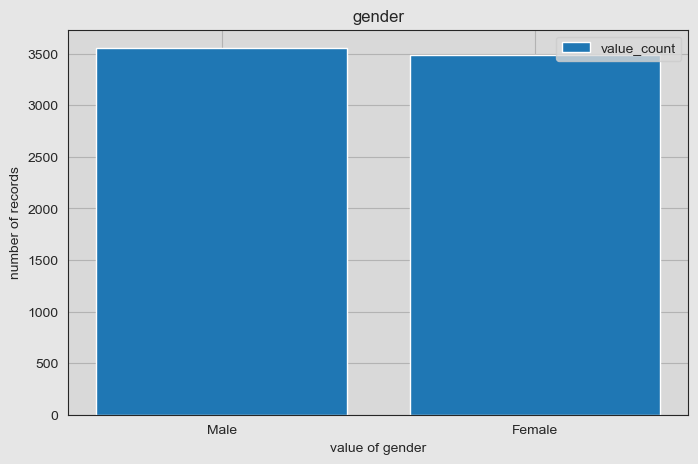

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64

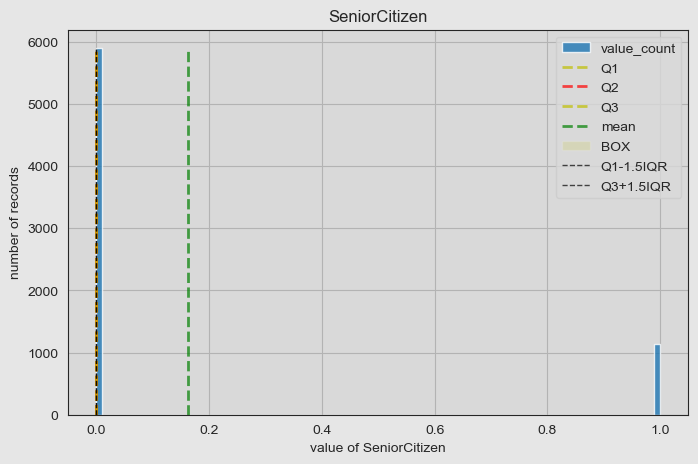

count     7043
unique       2
top         No
freq      3641
Name: Partner, dtype: object

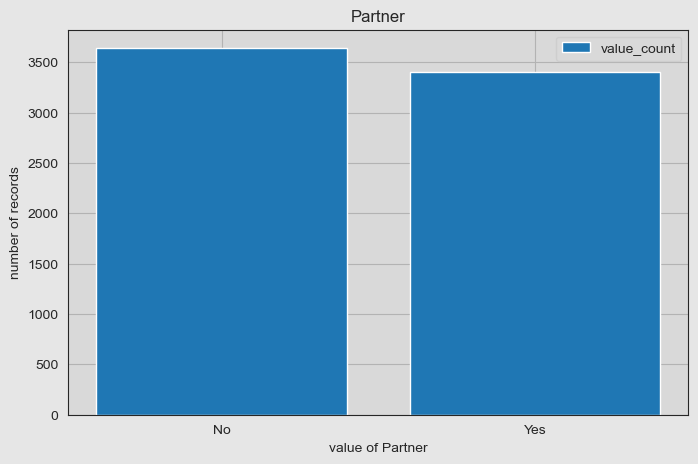

count     7043
unique       2
top         No
freq      4933
Name: Dependents, dtype: object

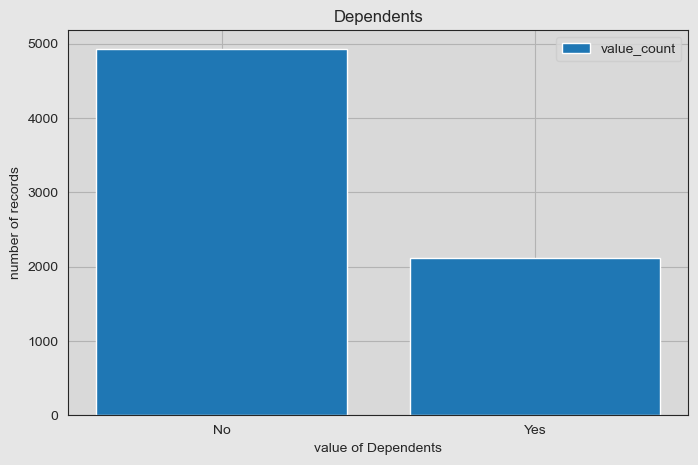

In [23]:
analyze_frame(df_personal, 'personal', column_for_gist['personal'])

Выводы по df_personal:  
- Число записей в таблице 7043;  
- Пропусков и дубликатов не обнаружено;  
- Все колонки имеют категориальный тип данных;  
- Некорректных значений в колонках не обнаружено.


### df_internet

Name tabel: internet
Общее число записей в таблице: 5517 

Info about columns 



,data_type,non-null,null,percent_null,n_unique
customerID,object,5517,0,0.0,5517
InternetService,object,5517,0,0.0,2
OnlineSecurity,object,5517,0,0.0,2
OnlineBackup,object,5517,0,0.0,2
DeviceProtection,object,5517,0,0.0,2
TechSupport,object,5517,0,0.0,2
StreamingTV,object,5517,0,0.0,2
StreamingMovies,object,5517,0,0.0,2




Number of duplicates: 0 

Посмотрим на распределения признаков 



count            5517
unique              2
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

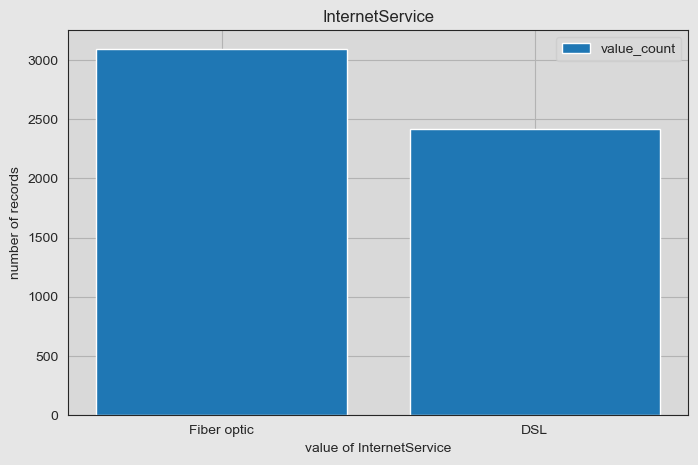

count     5517
unique       2
top         No
freq      3498
Name: OnlineSecurity, dtype: object

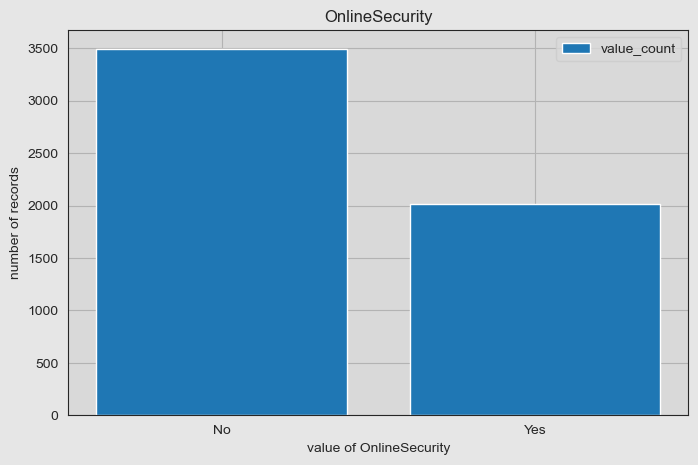

count     5517
unique       2
top         No
freq      3088
Name: OnlineBackup, dtype: object

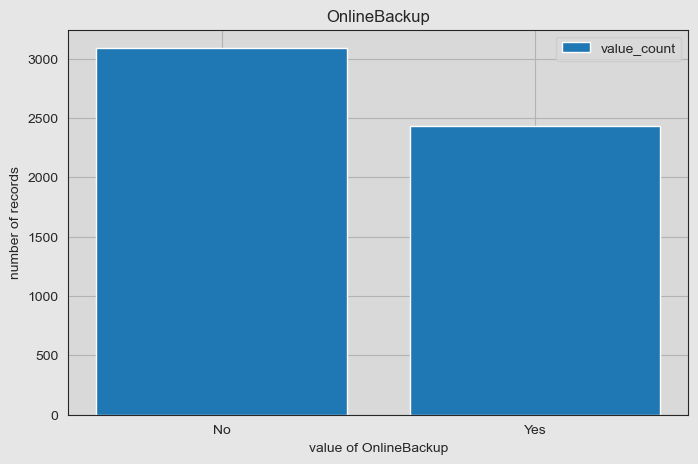

count     5517
unique       2
top         No
freq      3095
Name: DeviceProtection, dtype: object

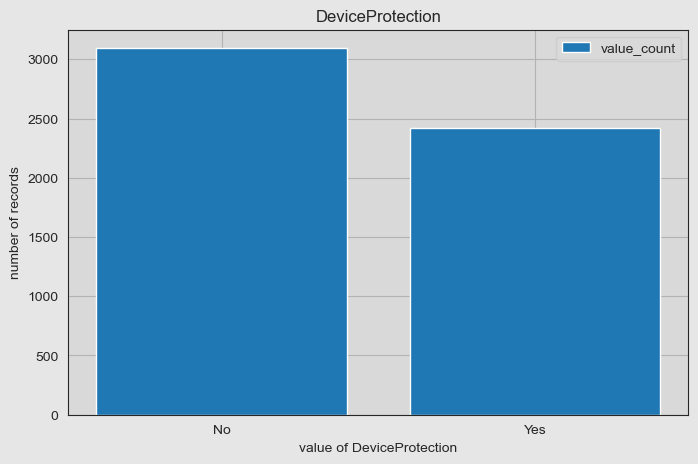

count     5517
unique       2
top         No
freq      3473
Name: TechSupport, dtype: object

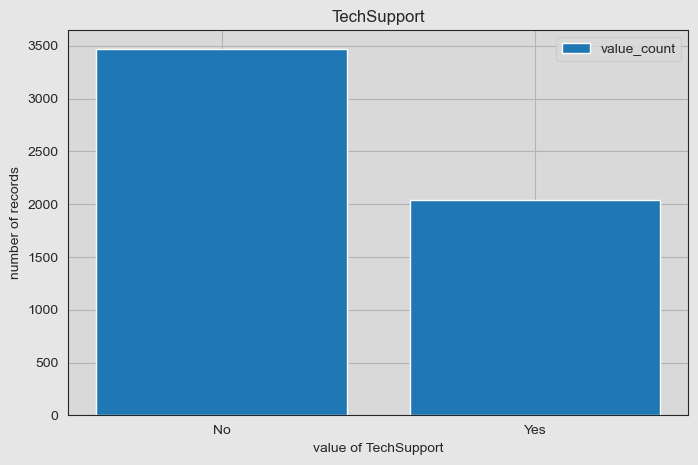

count     5517
unique       2
top         No
freq      2810
Name: StreamingTV, dtype: object

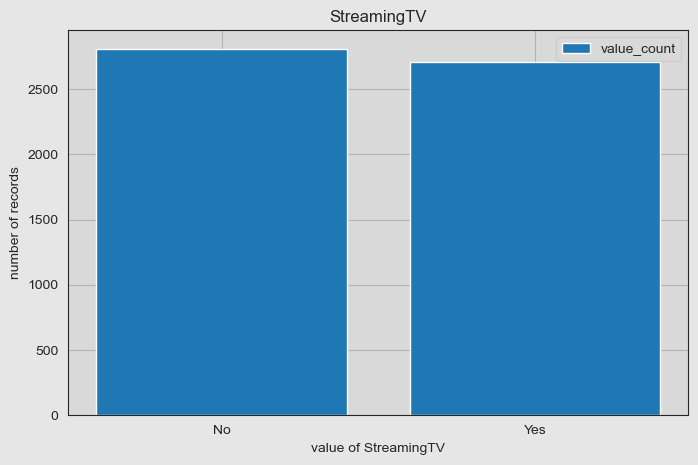

count     5517
unique       2
top         No
freq      2785
Name: StreamingMovies, dtype: object

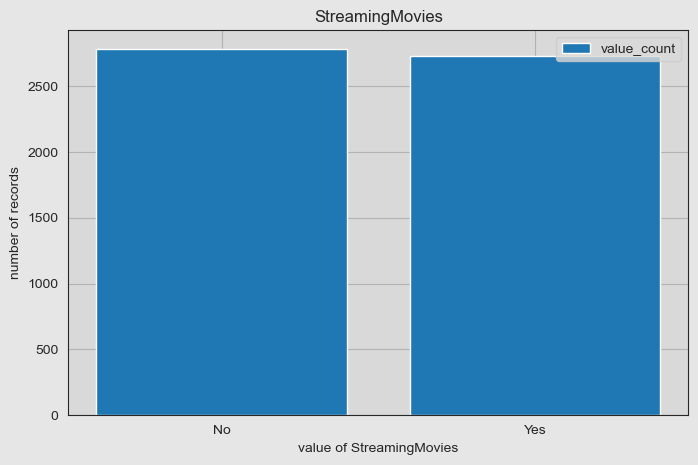

In [24]:
analyze_frame(df_internet, 'internet', column_for_gist['internet'])

Выводы по df_internet:  
- Число записей в таблице составляет 5517, следовательно 1526 клиентов не пользуются услугами интернета;  
- Все колонки являются категориальными; 
- Пропуски и дубликаты не обнаружены;  
- Некорректных значений в колонках не обнаружено.


### df_phone

Name tabel: phone
Общее число записей в таблице: 6361 

Info about columns 



,data_type,non-null,null,percent_null,n_unique
customerID,object,6361,0,0.0,6361
MultipleLines,object,6361,0,0.0,2




Number of duplicates: 0 

Посмотрим на распределения признаков 



count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object

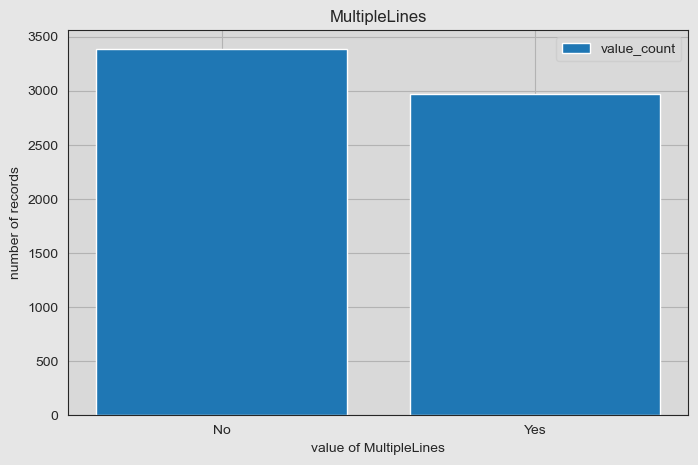

In [25]:
analyze_frame(df_phone, 'phone', column_for_gist['phone'])

Вывод по df_phone:  
- Число записей в таблице составляет 6361, следовательно 682 клиента не пользуются стационарной телефонной связью;  
- Пропусков и дубликатов не обнаружено.

### Объединение таблиц и генерация новых признаков

Объединим таблицы по customerID

In [26]:
full_df = df_contract.merge(df_personal, on='customerID', how='inner')
full_df = full_df.merge(df_internet, on='customerID', how='left')
full_df = full_df.merge(df_phone, on='customerID', how='left')

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Добавим новый признак HavePhone, обозначающий наличие стационарного телефона

In [27]:
full_df['HavePhone'] = (~full_df['MultipleLines'].isna())

Пропуски в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines заменим на значение "No". 

In [28]:
for column in ['InternetService', 
               'OnlineSecurity',
               'OnlineBackup',
               'DeviceProtection', 
               'TechSupport', 
               'StreamingTV', 
               'StreamingMovies', 
               'MultipleLines']:
    
    full_df[column] = full_df[column].fillna('No')

In [29]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Создадим новый признак длительности контракта

In [30]:
full_df['ContractDuration'] = (full_df['EndDate'].fillna('2020-02-01') - full_df['BeginDate']).apply(lambda x: x.days)

In [31]:
full_df['BeginYear'] = pd.DatetimeIndex(full_df['BeginDate']).year
full_df['BeginMonth'] = pd.DatetimeIndex(full_df['BeginDate']).month

Создадим новый признак равный произведению месячный трат на длительность контракта и на 1/30

In [32]:
full_df['CD_x_M_Charges'] = full_df['ContractDuration'] / 30 * full_df['MonthlyCharges']

Создадим целевую переменную из признака EndDate

In [33]:
full_df['target'] = (~full_df['EndDate'].isna()).astype('int')

### Анализ объединенного датасета

In [34]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Определим переменные с названиями категориальных и числовых признаков и целевой переменной

In [35]:
num_columns = ['MonthlyCharges',
               'TotalCharges',
               'ContractDuration',
               'CD_x_M_Charges']

cat_columns = ['Type',
               'PaperlessBilling',
               'PaymentMethod',
               'gender',
               'SeniorCitizen',
               'Partner',
               'Dependents',
               'InternetService',
               'OnlineSecurity',
               'OnlineBackup',
               'DeviceProtection',
               'TechSupport',
               'StreamingTV',
               'StreamingMovies',
               'MultipleLines',
               'HavePhone',
               'BeginYear',
               'BeginMonth']

target = 'target'

Напишем функцию для построения диаграмм для числовых и категориальных признаков

In [36]:
def distribution_of_features(data: pd.DataFrame, 
                             column: str, 
                             target: str, 
                             mode: str,
                             figsize: list = [10, 6],
                             bins: int = 20):

    if mode == 'hist':

        title = f'distribution of {column}'
        x_label = 'value of ' + column
        y_label = 'number of records'

        good_cases = data[data[target] == 0]
        bad_cases = data[data[target] == 1]
        max_numb = max_number(good_cases, column, bins+1)

        plt.figure(figsize=figsize)
    
        good_cases[column].plot(kind='hist', bins=bins, 
                                grid=True, alpha=0.9,
                                color = 'deepskyblue')
        bad_cases[column].plot(kind='hist', bins=bins, 
                               grid=True, alpha=0.7,
                               color = 'orange')
    
        plt.vlines(good_cases[column].mean(), 0, max_numb, color='darkblue', linewidth=2, 
                   linestyle='--', alpha=0.7)
        plt.vlines(bad_cases[column].mean(), 0, max_numb, color='red', linewidth=2, 
                   linestyle='--', alpha=0.7)
        plt.vlines(good_cases[column].median(), 0, max_numb, color='blue', linewidth=2, 
                   linestyle='--', alpha=0.7)
        plt.vlines(bad_cases[column].median(), 0, max_numb, color='orangered', linewidth=2, 
                   linestyle='--', alpha=0.7)
    
        plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты',
                    'Среднее для оставшихся клиентов',
                    'Среднее для ушедших клиентов',
                    'Медиана для оставшихся клиентов',
                    'Медиана для ушедших клиентов'])
        
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    
        plt.show()

    if mode == 'pie':  

        p = data.pivot_table(index = column, 
                             values = target,
                             aggfunc = ['count', 'sum'])
        p.columns = ['count', 'bad']
        p['good'] = p['count'] - p['bad']

        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        plt.pie(x=p['bad'].values, explode=np.ones(p.shape[0])*0.1, shadow=True, 
                labels=p.index, autopct='%1.1f%%')
        plt.title(f'Distribution of {column} among dead customers')
        plt.legend(p['bad'].values)
        
        plt.subplot(1, 2, 2)
        plt.pie(x=p['good'].values, explode=np.ones(p.shape[0])*0.1, shadow=True, 
                labels=p.index, autopct='%1.1f%%')
        plt.title(f'Distribution of the {column} among live customers')
        plt.legend(p['good'].values)
        
        plt.show()

Построим графики распределения числовых признаков

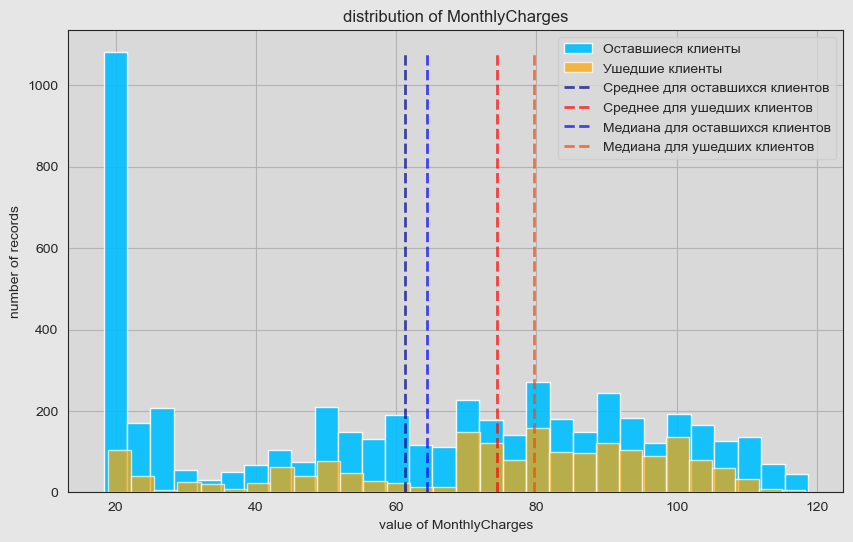

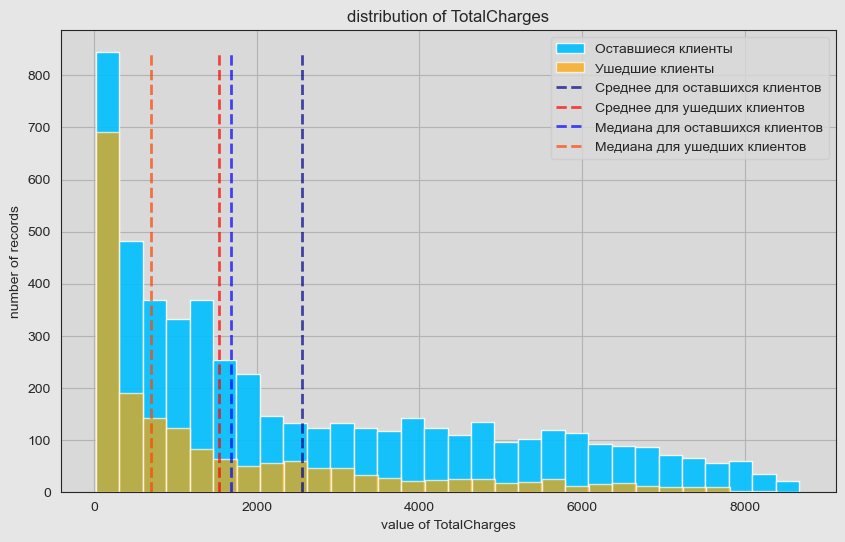

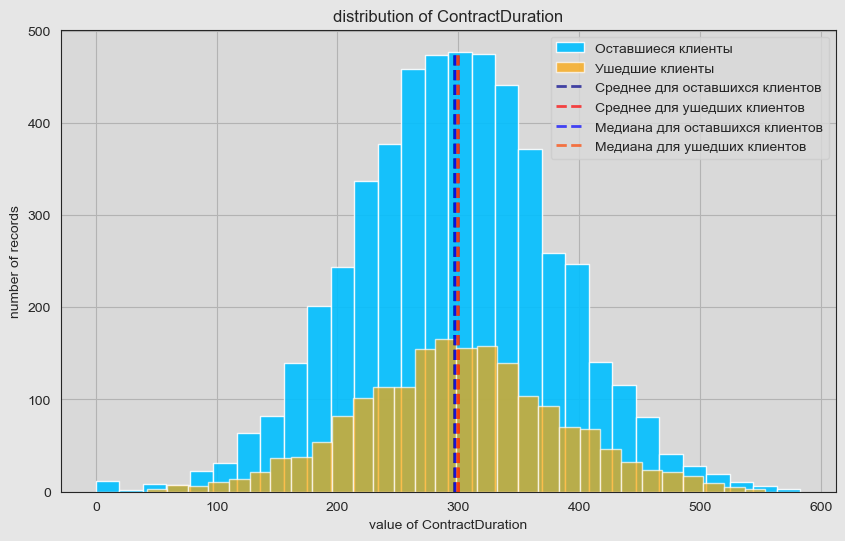

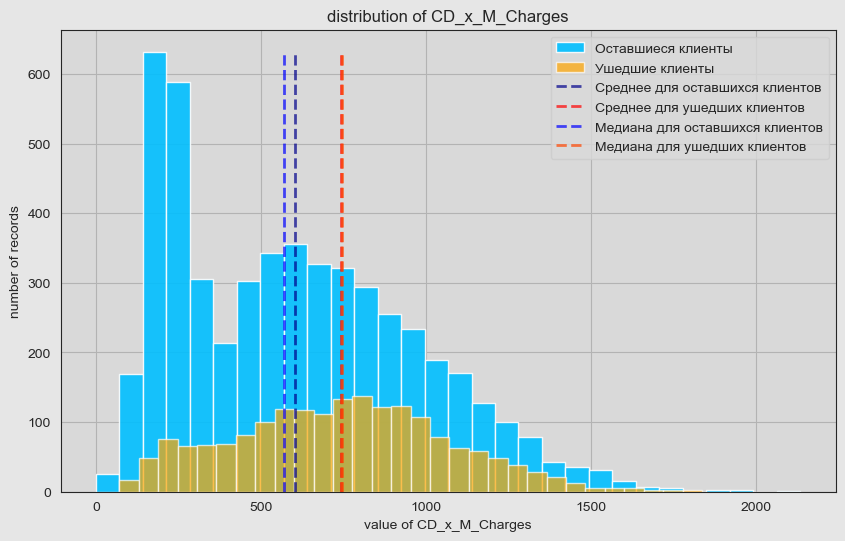

In [37]:
for column in num_columns:

    distribution_of_features(full_df, 
                             column,
                             target,
                             'hist', 
                             bins=30)

Выводы по числовым признакам:  
- Средние месячные траты ушедших клиентов выше, чем оставшихся;  
- Длительность контракта для обоих категорий клиентов имеет одинаковое нормальное распределение, средние и медианные показатели отличаются крайне незначительно;  
- Сгенерированный признак CD_x_M_Charges показывает различные средние показатели для ушедших и оставшихся клиентов. 

Построим диаграммы распределения категориадьных признаков

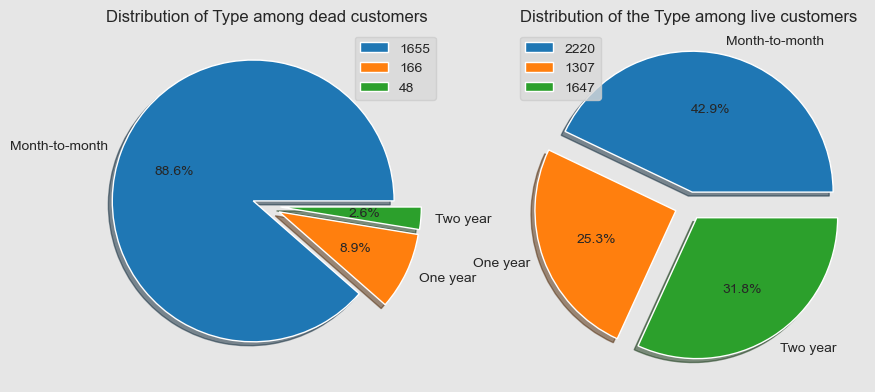

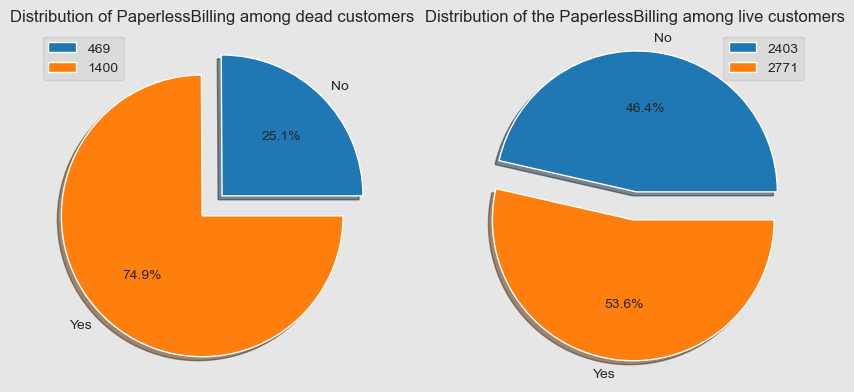

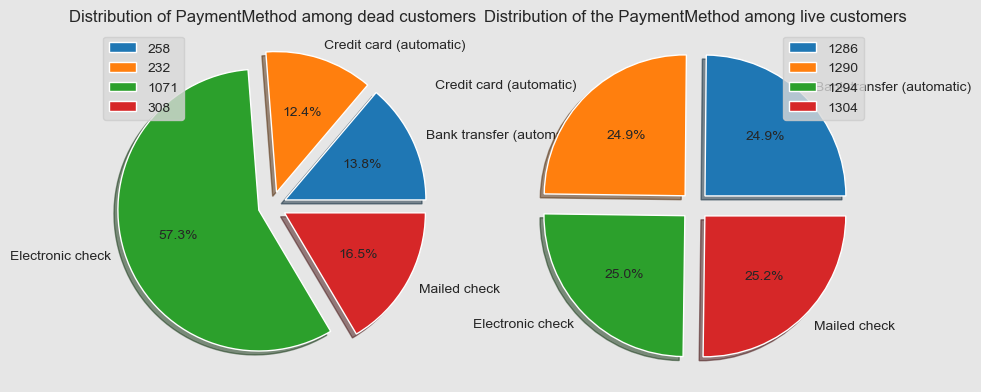

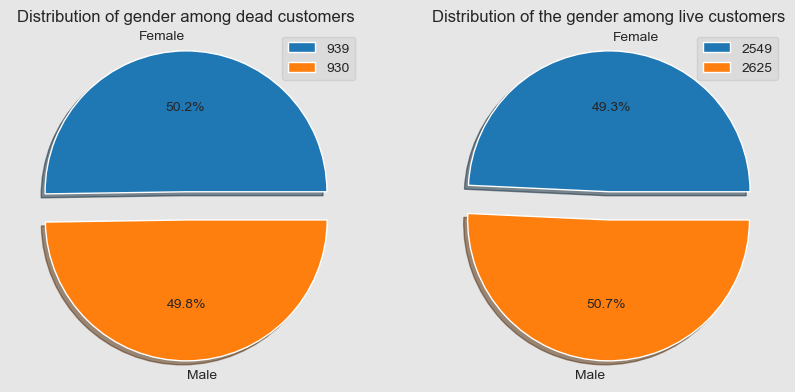

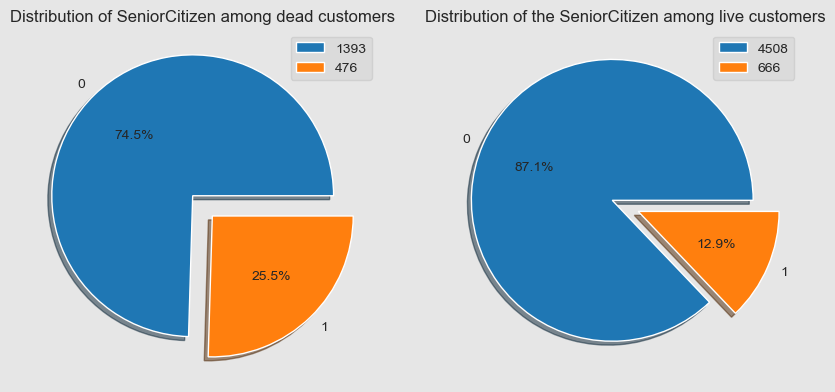

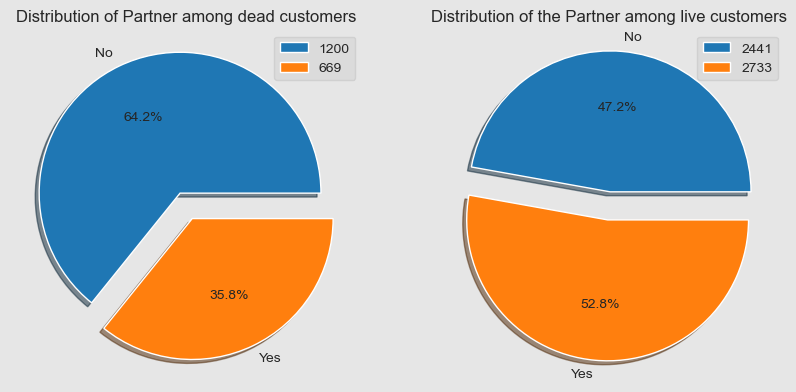

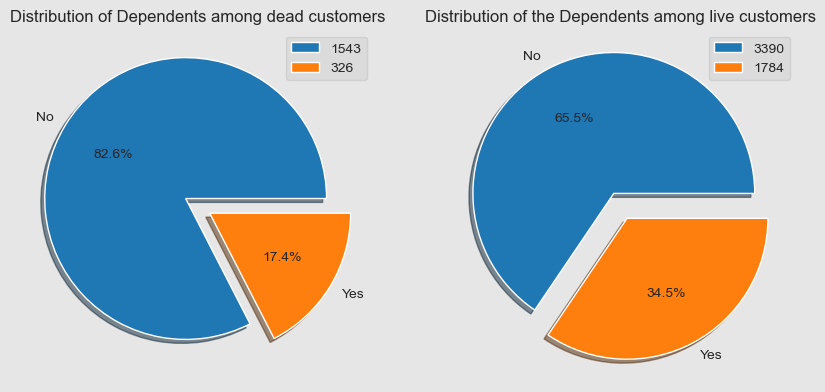

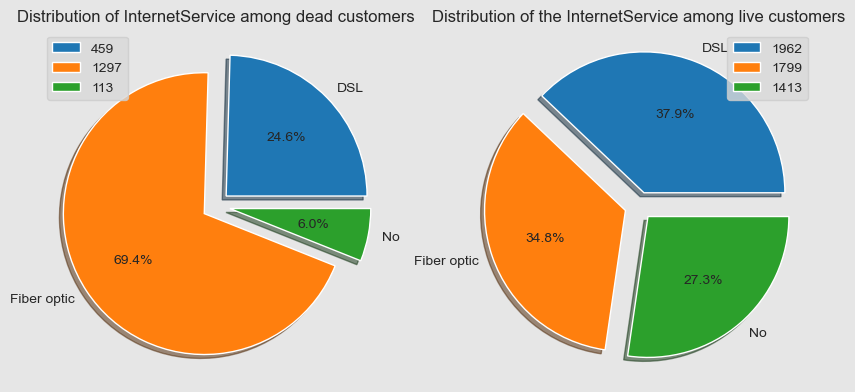

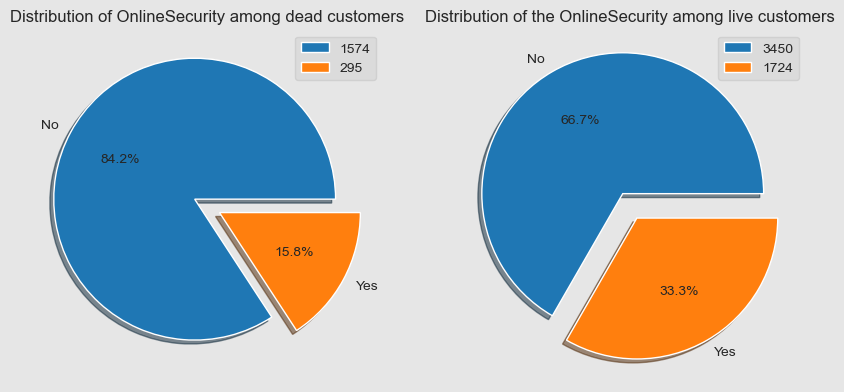

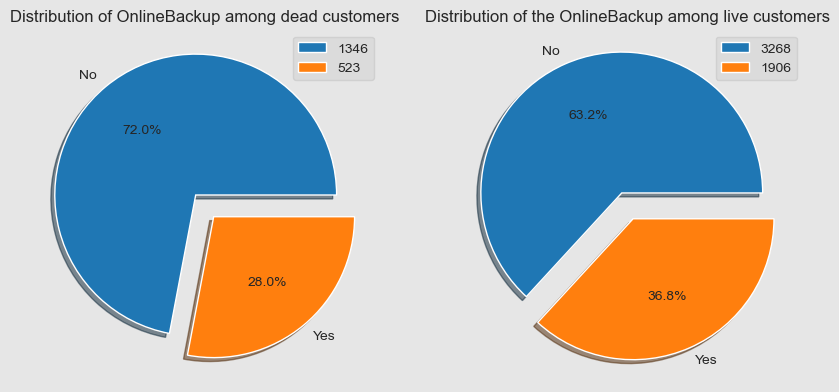

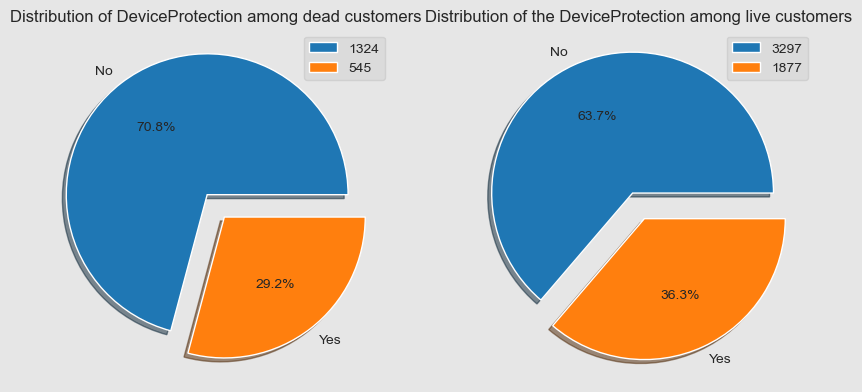

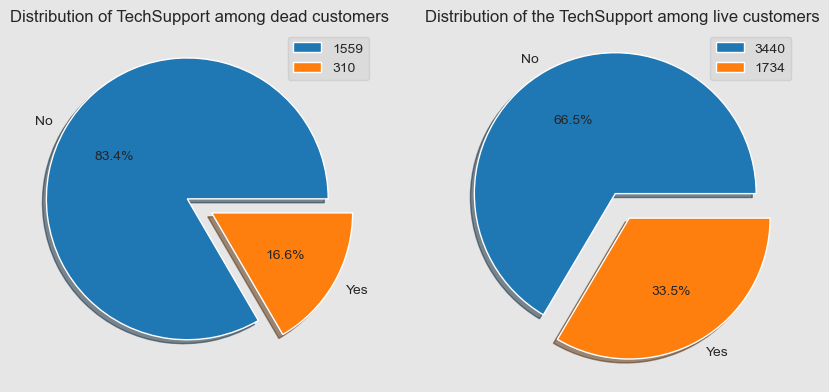

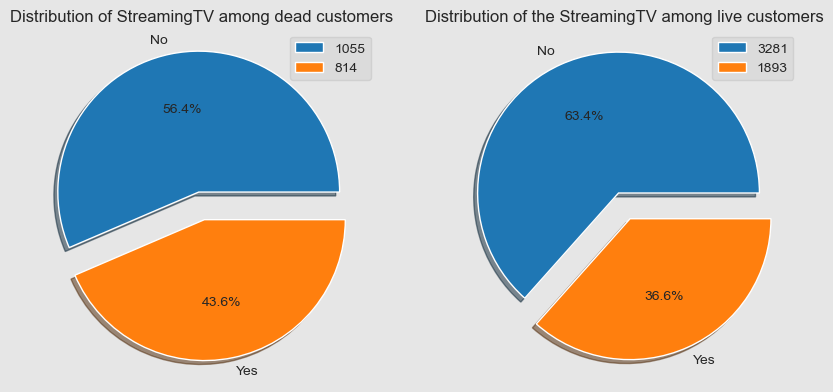

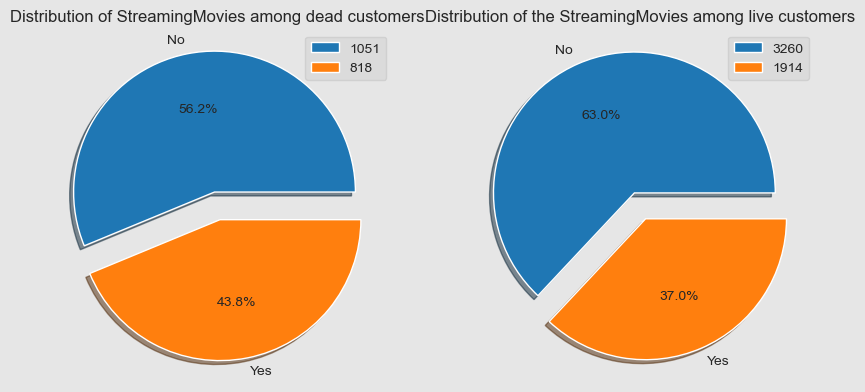

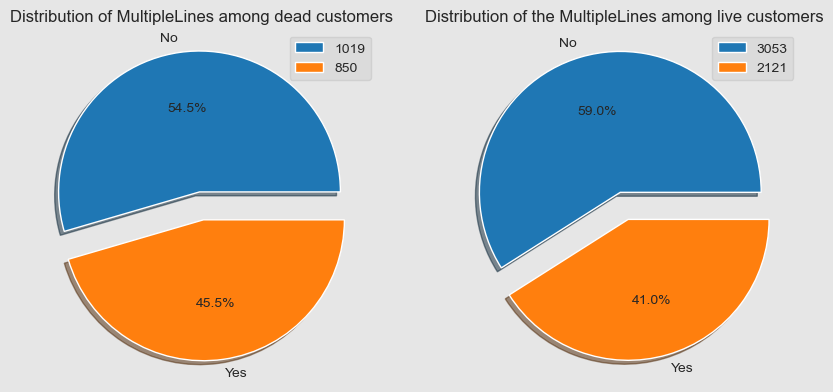

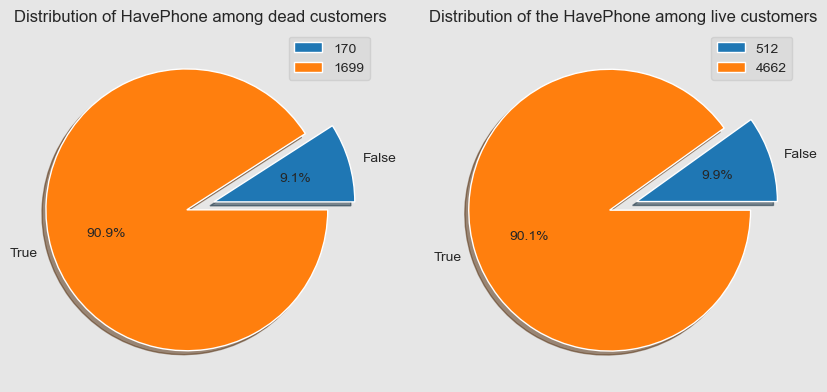

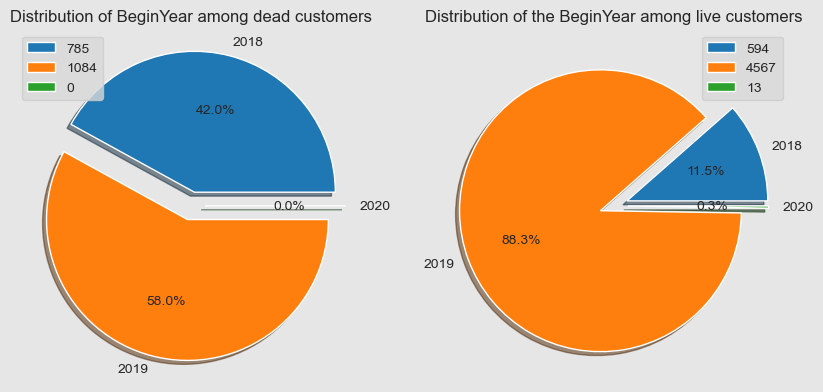

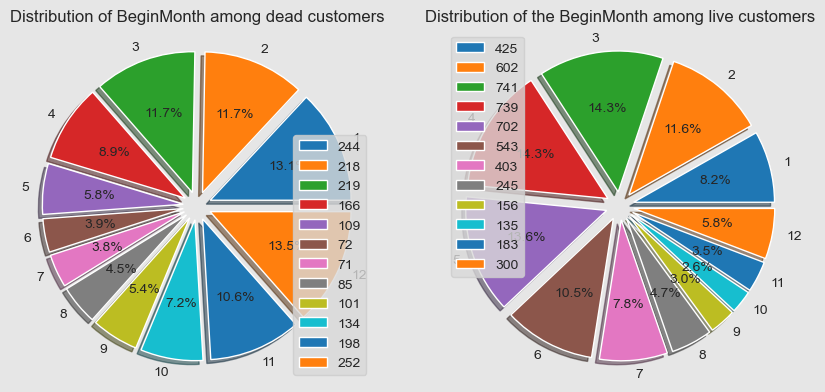

In [38]:
for column in cat_columns:

    distribution_of_features(full_df, 
                             column,
                             target,
                             'pie')

Вывод по категориальным признакам:  
- Подавляющее большинство ушедших клиентов осуществляло оплату каждый месяц;  
- Более половины оставшихся клиентов осуществляет оплату за год или два;  
- 75 % ушедших клиентов имеют электронный расчетный лист;  
- Методы оплаты среди оставших клиентов распределены равномерно, среди ушедших клиентов преобладает категория оплаты Electronic check (57.3 %);  
- Пол для обеих категорий клиентов распределен равномерно;  
- Среди ушедших клиентов доля пенсионеров в два раза выше, чем среди оставшихся;  
- Среди ушедших клиентов доля женатых на 17 % меньше;  
- Также ушедшие клиенты имеют детей на 17 % меньше, чем оставшиеся;  
- Подавляющее большинство ушедших клиентов (94%) пользовались услугой интернета и 70% из них имели оптиковолоконное подключение в то время, как среди оставшихся клиентов интернетом пользуются 73% людей;  
- Среди ушедших доля использования блокировки опасный сайтов в два раза ниже, чем для оставшихся клиентов;  
- Использование облачного хранилища незначительно отличается для обеих категорий клиентов, для оставшихся на 8 % выше;  
- Использование антивируса незначительно отличается для обеих категорий клиентов, для оставшихся на 7 % выше;  
- Оставшиеся клиенты в два раза чаще пользуются выделенной линией технической поддержки, чем ушедшие клиенты;  
- Доля использования стримингового телевиления незначительно отличается для обеих категорий клиентов, для ушедших больше на 7%;  
- Доля использования каталога фильмов незначительно отличается для обеих категорий клиентов, для ушедших больше на 7%;  
- Распределение подключения телефона к нескольким линиям связи одновременно незначительно отличается для обеих категорий клиентов, для ушедших на 4% больше;  
- Признак пользования услугой стационарного телефона имеет одинаковое распределение для обеих категорий клиентов;  
- Доля ушедших клиентов заключивших договор в 2018 годы почти в 4 раза выше, чем для оставшихся;  
- Месяц заключения договора не позволяет провести четкую границу между ушедшими и оставшимися клиентами.   

С помощью теста Х^2 на независимость проверим зависимы ли выборки категориальных признаков для ушедших и оставшихся клиентов.  

Для этого сформируем:  
- нулевую гипотезу для каждого категориального признака: выборки признака независимы для ушедших и оставшихся клиентов. 
- альтернативную гипотезу: выборки признаков для ушедших и оставшихся клиентов связаны.  

Следовательно, если для каких-либо признаков нулевая гипотеза будет отвергнута, мы не сможем их использовать для обучения, так как они будут неинформативными.  

Значение порога статистической значимости примем равным 0.05. Соответствующая глобальная переменная ALPHA определена в начале ноутбука. 

Напишем функцию для тестирования признаков

In [39]:
def chi2_test_for_features(data, column, target):

    p = data.pivot_table(index = column, 
                         values = target,
                         aggfunc = ['count', 'sum'])

    p.columns = ['count', 'bad']
    p['good'] = p['count'] - p['bad']
    
    stat, p_value, dof, expected = chi2_contingency(p[['bad', 'good']])

    return p_value

Протестируем категориальные признаки и выведем результат

In [40]:
p_values_features = []

for column in cat_columns:
    p_value = chi2_test_for_features(full_df, column, target)
    p_values_features.append(p_value)

est_features = pd.Series(p_values_features, 
                         index = cat_columns)

est_features > ALPHA

Type                False
PaperlessBilling    False
PaymentMethod       False
gender               True
SeniorCitizen       False
Partner             False
Dependents          False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
MultipleLines       False
HavePhone            True
BeginYear           False
BeginMonth          False
dtype: bool

Тест Х2 позволил отклонить нулевую гипотезу для двух признаков gender и HavePhone

Выведем матрицу phik-корреляции для всех числовых и категориальных признаков

In [41]:
full_df[num_columns + cat_columns + [target]].phik_matrix().style.background_gradient('coolwarm')

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'CD_x_M_Charges', 'SeniorCitizen', 'BeginYear', 'BeginMonth', 'target']


,MonthlyCharges,TotalCharges,ContractDuration,CD_x_M_Charges,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,HavePhone,BeginYear,BeginMonth,target
MonthlyCharges,1.000000,0.762889,0.015962,0.798806,0.388444,0.467812,0.399526,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.831362,0.033072,0.100459,0.360050
TotalCharges,0.762889,1.000000,0.010908,0.539256,0.505287,0.205901,0.350460,0.000000,0.148755,0.422402,0.114304,0.508171,0.544407,0.655082,0.671222,0.565910,0.659672,0.666350,0.605753,0.197703,0.052653,0.078230,0.279152
ContractDuration,0.015962,0.010908,1.000000,0.688339,0.037860,0.050069,0.000868,0.000000,0.034522,0.016432,0.035546,0.030204,0.000000,0.032195,0.022743,0.000000,0.048799,0.053546,0.000000,0.000000,0.666914,0.881277,0.034597
CD_x_M_Charges,0.798806,0.539256,0.688339,1.000000,0.200075,0.398060,0.336149,0.000000,0.256359,0.107901,0.146897,0.778668,0.370486,0.483251,0.512137,0.389288,0.662589,0.652443,0.532107,0.378606,0.137339,0.506337,0.251934
Type,0.388444,0.505287,0.037860,0.200075,1.000000,0.106860,0.277462,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.000000,0.036564,0.119707,0.251639
PaperlessBilling,0.467812,0.205901,0.050069,0.398060,0.106860,1.000000,0.370495,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.016811,0.011750,0.032186,0.295754
PaymentMethod,0.399526,0.350460,0.000868,0.336149,0.277462,0.370495,1.000000,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.000000,0.054874,0.079208,0.449125
gender,0.008175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.304985,0.148755,0.034522,0.256359,0.086231,0.242133,0.292725,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.000000,0.012118,0.028882,0.233432
Partner,0.203545,0.422402,0.016432,0.107901,0.179736,0.013218,0.243008,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.019540,0.028209,0.038552,0.232930


Выводы по phik-корреляции:  
- Признаки с месячными и общими расходами клиентов сильно коррелируют со всеми признаки из таблиц internet и phone;  
- Сгенерированный признак длительности контракта практически не коррелирует с другими переменными, но также мало оказывает влияние на целевую перевенную;  
- Признак gender имеет нулевую корреляцию со всеми признаками и также с целевой переменной;  
- Целевая переменная таргет меньше всего коррелирует с признаками HavePhone, ContrackDuartion, gender.  
- Самая сильная коррелиция целевой переменной с признаками MontlyCharges и PaymentMethod.  

Посмотрим на распределение целевой переменной среди числовых признаков

<Figure size 3000x3000 with 0 Axes>

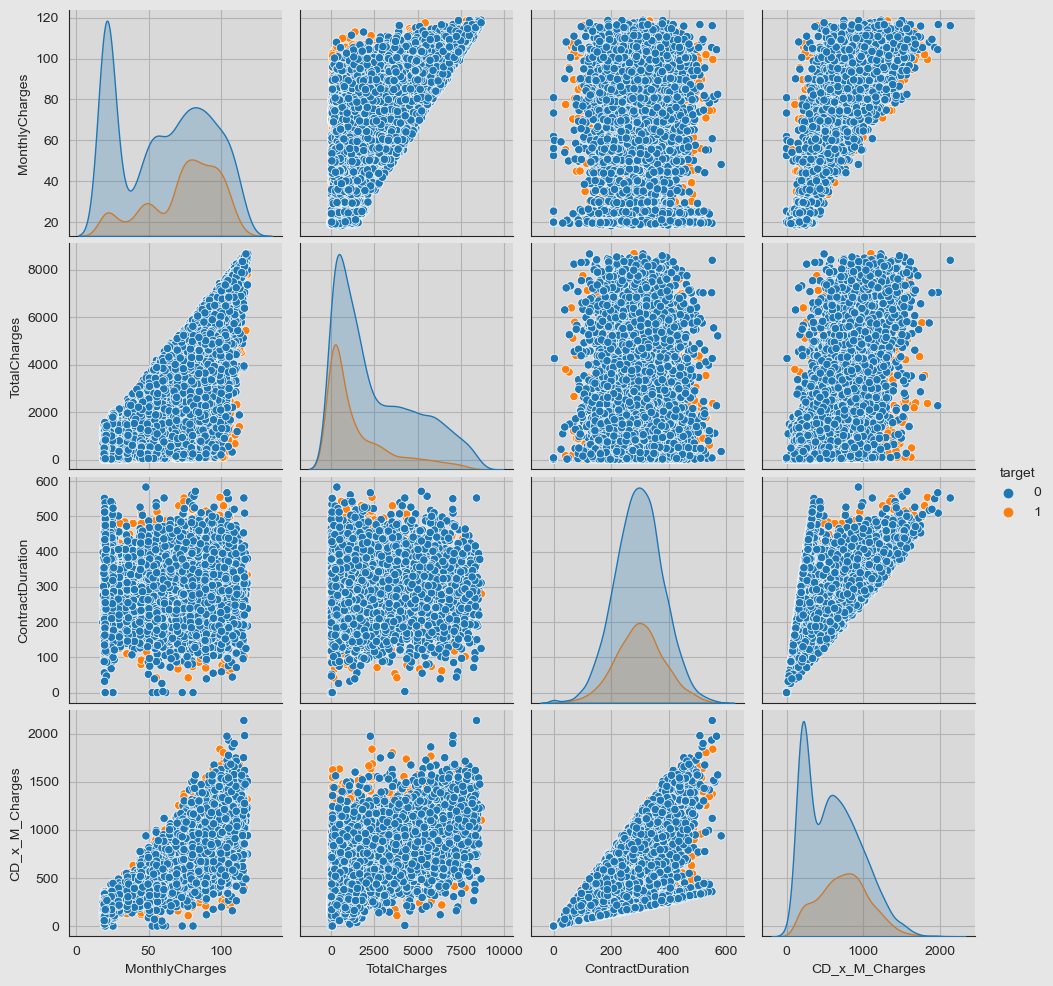

In [42]:
plt.figure(figsize=(30, 30))
sns.pairplot(full_df[num_columns + [target]],
             hue=target)
plt.show()

Посмотрим на баланс целевой переменной

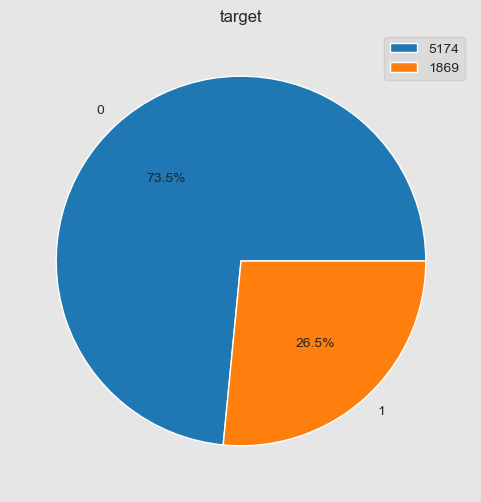

In [43]:
plt.figure(figsize=(6, 6))

freq = full_df['target'].value_counts()
plt.pie(x=freq.values, labels=freq.index, autopct='%1.1f%%')
plt.title('target')
plt.legend(freq.values)

plt.show()

Как видно из диаграммы соотношение значений целевой переменной примерно 1/3. Классы не сбалансированы.

Общий вывод по исследованию признаков:  
- Числовые признаки:  
    - Исключим признак длительности контракта ContrackDuration, поскольку он неинформативный и не позволяет разделить ушедших и оставшихся клиентов;  
    - Исключим сгенериррованный признак CD_x_M_Charges, поскольку он сильно коррелирует с признаков MontlyCharges;  

- Категориальные признаки:  
    - Исключим признак gender, поскольку он не прошел тест X2 на связанность и является неинформативным;  
    - Исключим признак HavePhone, поскольку он также не прошел тест X2 на связанность и является неинформативным;  
    - Исключим признак BeginMonth, поскольку он является не информативным и не позволяет выявить различия между ушедшими и оставшимися клиентами.  

Дальнейшие преобразования:  
- Категориальные бинарные признаки преобразуем к числовому типу;  
- Числовые признаки будем шкалировать для линейных моделей, для моделей на основе деревьев решений оставим без изменений;  
- Категориальные признаки с более чем двумя значениями закодируем методом OHE для линейных моделей, и OrdinalEncoder для "деревянных" моделей.

### Подготовка данных к обучению

In [44]:
cat_bin_columns = ['PaperlessBilling',
                   'Partner',
                   'Dependents',
                   'OnlineSecurity',
                   'OnlineBackup',
                   'DeviceProtection',
                   'TechSupport',
                   'StreamingTV',
                   'StreamingMovies',
                   'MultipleLines',
                   'HavePhone']

Приведем бинарные признаки к числовому виду

In [45]:
for column in cat_bin_columns:
    full_df[column] = (full_df[column] == 'Yes').astype('int')

In [46]:
full_df['SeniorCitizen'] = full_df['SeniorCitizen'].astype('int32')

Определим переменные с хорошими числовыми, категориальными и бинарными признаками

In [47]:
good_num_features = ['MonthlyCharges',
                     'TotalCharges',
                     'BeginYear']

good_cat_features = ['Type', 
                     'PaymentMethod',
                     'InternetService']

good_bin_features = ['PaperlessBilling',
                     'SeniorCitizen',
                     'Partner',
                     'Dependents',
                     'OnlineSecurity',
                     'OnlineBackup',
                     'DeviceProtection',
                     'TechSupport',
                     'StreamingTV',
                     'StreamingMovies',
                     'MultipleLines']

good_features = good_num_features + good_cat_features + good_bin_features

Получим итоговый датасет с отобранными признаками, отдельно признаковое описание и целевую переменную

In [48]:
final_df = full_df[good_features + [target]]

X = final_df[good_features]
y = final_df[target]

Разделим выборку на тренировочную и тестовую

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)

## Обучение моделей

Исследовать будем три вида моделей:  
- Случайный лес;  
- Градиентный бустинг;  
- Полносвязанная нейросеть.

Определим сетки гиперпараметров для обучения Случайного леса и Градиентного Бустинга

In [50]:
param_grid_RFC = {'randomforestclassifier__n_estimators': [16, 32, 64, 128, 256, 512],
                  'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
                  'randomforestclassifier__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

param_grid_CB = {'catboostclassifier__n_estimators': [8, 16, 32, 64, 128, 256, 512],
                 'catboostclassifier__depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

Напишем функцию для обучения моделей

In [51]:
def fit_model(model, params, scoring, refit,
              X_train, y_train, cv=5):

    #Определим модель
    est_model = GridSearchCV(model,
                             params,
                             cv=cv,
                             verbose=1,
                             scoring=scoring,
                             refit = refit, 
                             n_jobs=-1)

    #Обучим модель
    est_model.fit(X_train, y_train)

    #Выведим на экран лучший score и лучшие гиперпараметры
    print('best score:', est_model.best_score_)
    print('best parametrs:', est_model.best_params_)

    #Сохраним лучшую модель
    best_model = est_model.best_estimator_

    return best_model

### Случайный лес

Определим модель случайного леса и подберем гиперпараметры

In [52]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), good_num_features),
    ('encoder', OneHotEncoder(), good_cat_features)])
 
est_model_1 = make_pipeline(preprocessor, 
                            RandomForestClassifier(random_state=RANDOM_STATE, 
                                                   class_weight='balanced'))

scoring = {
    'f1_score': make_scorer(f1_score),
    'auc_roc': make_scorer(roc_auc_score)
}

RF_model = fit_model(est_model_1, param_grid_RFC, scoring, 'auc_roc',
                     X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


best score: 0.7904027536831955
best parametrs: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 128}


scoring

Лучшее достигнутое значение метрики ROC-AUC = 0.79, при следующих параметрах:  
- criterion: gini;  
- max_depth: 7;  
- n_estimators: 128.

### Градиентный бустинг

Определим модель градиентного бустинга и подберем гиперпараметры

In [53]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), good_num_features),
    ('encoder', OneHotEncoder(), good_cat_features)])
 
est_model_2 = make_pipeline(preprocessor, 
                            cb.CatBoostClassifier(auto_class_weights='Balanced',
                                                  custom_loss='AUC',
                                                  random_seed=RANDOM_STATE))

scoring = {
    'f1_score': make_scorer(f1_score),
    'auc_roc': make_scorer(roc_auc_score)
}

CB_model = fit_model(est_model_2, param_grid_CB, scoring, 'auc_roc',
                     X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


Learning rate set to 0.5
0:	learn: 0.5540118	total: 134ms	remaining: 2.02s
1:	learn: 0.5005253	total: 136ms	remaining: 952ms
2:	learn: 0.4739736	total: 138ms	remaining: 599ms
3:	learn: 0.4539957	total: 149ms	remaining: 447ms
4:	learn: 0.4502317	total: 150ms	remaining: 329ms
5:	learn: 0.4374459	total: 160ms	remaining: 266ms
6:	learn: 0.4320060	total: 162ms	remaining: 208ms
7:	learn: 0.4313674	total: 163ms	remaining: 163ms
8:	learn: 0.4251005	total: 173ms	remaining: 134ms
9:	learn: 0.4196891	total: 184ms	remaining: 110ms
10:	learn: 0.4144312	total: 193ms	remaining: 87.8ms
11:	learn: 0.4142751	total: 195ms	remaining: 64.9ms
12:	learn: 0.4122052	total: 201ms	remaining: 46.5ms
13:	learn: 0.4104934	total: 203ms	remaining: 29ms
14:	learn: 0.4079465	total: 215ms	remaining: 14.3ms
15:	learn: 0.4050591	total: 227ms	remaining: 0us
best score: 0.793889236840864
best parametrs: {'catboostclassifier__depth': 10, 'catboostclassifier__n_estimators': 16}


Лучшее достигнутое значение метрики ROC-AUC = 0.794 при следующих параметрах:  
- depth: 10;  
- n_estimators: 16.

### Полносвязанная нейросеть

Для подбора гиперпараметров разделим тренировочную выборку еще и на валидационную с коэффициентом 0.2

In [54]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train, y_train, 
                                                                    test_size=0.2, 
                                                                    random_state=RANDOM_STATE, 
                                                                    stratify=y_train)

Закодируем категориальыне признаки методом OneHotEncoder

In [55]:
encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', 
                        feature_name_combiner='concat')

In [56]:
def OHE(encoder, train, valid, test, columns):  

    train_encode = train.copy()
    train_encode = train_encode.drop(columns, axis=1)

    valid_encode = valid.copy()
    valid_encode = valid_encode.drop(columns, axis=1)

    test_encode = test.copy()
    test_encode = test_encode.drop(columns, axis=1)

    for column in columns:

        encoder.fit(train[column].values.reshape(-1, 1))
    
        train_encode[encoder.get_feature_names_out([column])] = encoder.transform(train[column].values.reshape(-1, 1)).toarray()
        valid_encode[encoder.get_feature_names_out([column])] = encoder.transform(valid[column].values.reshape(-1, 1)).toarray()
        test_encode[encoder.get_feature_names_out([column])] = encoder.transform(test[column].values.reshape(-1, 1)).toarray()

    return train_encode, valid_encode, test_encode

In [57]:
X_train_encode, X_valid_encode, X_test_encode = OHE(encoder, 
                                                    X_train_nn, 
                                                    X_valid_nn, 
                                                    X_test, 
                                                    good_cat_features)

In [58]:
X_train_encode.shape, X_valid_encode.shape, X_test_encode.shape

((4225, 21), (1057, 21), (1761, 21))

Отшкалируем числовые признаки методом StandardScaler

In [59]:
scaler = StandardScaler()

X_train_encode_n_scal = X_train_encode.copy()
X_valid_encode_n_scal = X_valid_encode.copy()
X_test_encode_n_scal = X_test_encode.copy()

scaler.fit(X_train_encode[good_num_features])

X_train_encode_n_scal[good_num_features] = scaler.transform(X_train_encode[good_num_features])
X_valid_encode_n_scal[good_num_features] = scaler.transform(X_valid_encode[good_num_features])
X_test_encode_n_scal[good_num_features] = scaler.transform(X_test_encode[good_num_features])

Определим класс датасета для обучения

In [60]:
class NN_Dataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.len_ = len(data)

    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        X = self.data[index, :-1]
        y = self.data[index, -1]
        return X, y

Напишем функции для обучения

In [61]:
def fit_epoch(model, train_loader, Loss, optimizer):
    model.train(True)
    
    running_loss = 0.0
    processed_size = 0
    num_batch = 0
    running_auc = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = Loss(F.sigmoid(outputs.flatten()), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().item() * inputs.cpu().size(0)
        processed_size += inputs.size(0)
        num_batch += 1
        running_auc += roc_auc_score(targets.cpu().detach().numpy(), 
                       (F.sigmoid(outputs.flatten().cpu().detach())).numpy())
              
    train_loss = running_loss / processed_size
    train_auc = running_auc / num_batch
    
    return train_loss, train_auc


def eval_epoch(model, valid_loader, Loss):
    model.eval()

    running_loss = 0.0
    processed_size = 0
    num_batch = 0
    running_auc = 0

    for inputs, targets in valid_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = Loss(F.sigmoid(outputs.flatten()), targets)

        running_loss += loss.cpu().item() * inputs.cpu().size(0)
        processed_size += inputs.size(0)
        num_batch += 1
        running_auc += roc_auc_score(targets.cpu().detach().numpy(), 
                      (F.sigmoid(outputs.flatten().cpu().detach())).numpy())

    val_loss = running_loss / processed_size
    val_auc = running_auc / num_batch
    
    return val_loss, val_auc


def train(model, Loss, optimizer,
          train_loader, valid_loader, num_epochs, 
          scheduler=False, logs=False):
    
    model.to(DEVICE)

    best_model_wts = model.state_dict()
    best_loss = 100
    best_epoch = 0
    best_auc = 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_auc {t_auc:0.4f} val_auc {v_auc:0.4f}"

    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:

        for epoch in range(num_epochs):

            train_loss, train_auc = fit_epoch(model, train_loader, Loss, optimizer)
            valid_loss, valid_auc = eval_epoch(model, valid_loader, Loss)

            history.append((train_loss, train_auc, valid_loss, valid_auc))

            if logs:
                if epoch % 10 == 9:
                    pbar_outer.update(10)
                    tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                                   v_loss=valid_loss, t_auc=train_auc,\
                                                   v_auc=valid_auc))
            
            if best_auc < valid_auc:
                best_loss = valid_loss
                best_auc = valid_auc
                best_model_wts = model.state_dict()
                best_epoch = epoch + 1

            if scheduler:
                scheduler.step()

    model.load_state_dict(best_model_wts)

    print('best auc {0} on {1} epoch'.format(best_auc, best_epoch))
    return model, history, best_loss, best_auc

In [62]:
def print_losses(history):
    train_loss, train_auc, val_loss, val_auc = zip(*history)
    
    plt.figure(figsize=(8, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(2, 1, 2)
    plt.plot(train_auc, label="train_auc")
    plt.plot(val_auc, label="val_auc")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("auc_score")
    
    plt.show()

Определим классы сетей из которых будем подбирать лучшую

In [63]:
class MyNet_1_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 128)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(128, 128)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(128, 256)
        self.act_3 = nn.ReLU()
        self.layer_4 = nn.Linear(256, 256)
        self.act_4 = nn.ReLU()
        self.layer_5 = nn.Linear(256, 256)
        self.act_5 = nn.ReLU()
        self.layer_6 = nn.Linear(256, 256)
        self.act_6 = nn.ReLU()
        self.layer_7 = nn.Linear(256, 128)
        self.act_7 = nn.ReLU()
        self.layer_8 = nn.Linear(128, 128)
        self.act_8 = nn.ReLU()
        self.layer_9 = nn.Linear(128, 64)
        self.act_9 = nn.ReLU()
        self.layer_10 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.act_4(self.layer_4(x))
        x = self.act_5(self.layer_5(x))
        x = self.act_6(self.layer_6(x))
        x = self.act_7(self.layer_7(x))
        x = self.act_8(self.layer_8(x))
        x = self.act_9(self.layer_9(x))
        x = self.layer_10(x)
        return x
    
class MyNet_1_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 128)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(128, 128)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(128, 256)
        self.act_3 = nn.ELU()
        self.layer_4 = nn.Linear(256, 256)
        self.act_4 = nn.ELU()
        self.layer_5 = nn.Linear(256, 256)
        self.act_5 = nn.ELU()
        self.layer_6 = nn.Linear(256, 256)
        self.act_6 = nn.ELU()
        self.layer_7 = nn.Linear(256, 128)
        self.act_7 = nn.ELU()
        self.layer_8 = nn.Linear(128, 128)
        self.act_8 = nn.ELU()
        self.layer_9 = nn.Linear(128, 64)
        self.act_9 = nn.ELU()
        self.layer_10 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.act_4(self.layer_4(x))
        x = self.act_5(self.layer_5(x))
        x = self.act_6(self.layer_6(x))
        x = self.act_7(self.layer_7(x))
        x = self.act_8(self.layer_8(x))
        x = self.act_9(self.layer_9(x))
        x = self.layer_10(x)
        return x
    
class MyNet_1_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 128)
        self.act_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(128, 128)
        self.act_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(128, 256)
        self.act_3 = nn.LeakyReLU()
        self.layer_4 = nn.Linear(256, 256)
        self.act_4 = nn.LeakyReLU()
        self.layer_5 = nn.Linear(256, 256)
        self.act_5 = nn.LeakyReLU()
        self.layer_6 = nn.Linear(256, 256)
        self.act_6 = nn.LeakyReLU()
        self.layer_7 = nn.Linear(256, 128)
        self.act_7 = nn.LeakyReLU()
        self.layer_8 = nn.Linear(128, 128)
        self.act_8 = nn.LeakyReLU()
        self.layer_9 = nn.Linear(128, 64)
        self.act_9 = nn.LeakyReLU()
        self.layer_10 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.act_4(self.layer_4(x))
        x = self.act_5(self.layer_5(x))
        x = self.act_6(self.layer_6(x))
        x = self.act_7(self.layer_7(x))
        x = self.act_8(self.layer_8(x))
        x = self.act_9(self.layer_9(x))
        x = self.layer_10(x)
        return x

class MyNet_2_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(256, 1024)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(1024, 256)
        self.act_3 = nn.ReLU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x  
    
class MyNet_2_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(256, 1024)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(1024, 256)
        self.act_3 = nn.ELU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x 
    
class MyNet_2_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(256, 1024)
        self.act_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(1024, 256)
        self.act_3 = nn.LeakyReLU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x 

class MyNet_3_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(256, 512)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(512, 256)
        self.act_3 = nn.ReLU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x 
    
class MyNet_3_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(256, 512)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(512, 256)
        self.act_3 = nn.ELU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x 
    
class MyNet_3_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(256, 512)
        self.act_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(512, 256)
        self.act_3 = nn.LeakyReLU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x 

Определим Dataloader`ы

In [64]:
data_train = X_train_encode_n_scal.copy()
data_train['Target'] = y_train_nn

data_valid = X_valid_encode_n_scal.copy()
data_valid['Target'] = y_valid_nn

data_test = X_test_encode_n_scal.copy()
data_test['Target'] = y_test

train_dataset = NN_Dataset(torch.Tensor(data_train.values))
valid_dataset = NN_Dataset(torch.Tensor(data_valid.values))
test_dataset = NN_Dataset(torch.Tensor(data_test.values))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [65]:
nets = [MyNet_1_1, MyNet_1_2, MyNet_1_3,
        MyNet_2_1, MyNet_2_2, MyNet_2_3,
        MyNet_3_1, MyNet_3_2, MyNet_3_3]

Напишем функцию для подбора лучшей архитектуры сети

In [66]:
def nets_selection(models, train_loader, test_loader, 
                   epoch, logs):
    
    best_auc = 0
    best_i = 0
    best_model = None
    best_loss = 100
    best_history = None

    for i, model in enumerate(models):
        net = model()
        loss_fn = nn.BCELoss()
        optimizer_fn = optim.Adam(net.parameters(), lr=1e-4)

        model, history, loss, auc = train(net, 
                                          loss_fn,
                                          optimizer_fn,
                                          train_loader,
                                          test_loader,
                                          epoch,
                                          False,
                                          logs)
      
        if auc > best_auc:       
            best_i = i
            best_auc = auc
            best_model = model
            best_loss = loss
            best_history = history

    print(f'best model {models[best_i]} has number {best_i}\nauc = {best_auc}\nloss = {best_loss}')
    return best_model, best_auc, best_loss, best_history

Запустим обучение и подберем лучшую архитектуру

In [67]:
best_nn_model, best_nn_auc, best_nn_loss, best_nn_history = nets_selection(nets, 
                                                                           train_loader,
                                                                           valid_loader,
                                                                           300,
                                                                           False)

epoch:   0%|          | 0/300 [00:00<?, ?it/s]

epoch:   0%|          | 0/300 [01:03<?, ?it/s]


best auc 0.8809883928239014 on 51 epoch


epoch:   0%|          | 0/300 [01:03<?, ?it/s]


best auc 0.8870887781186634 on 244 epoch


epoch:   0%|          | 0/300 [01:03<?, ?it/s]


best auc 0.8859340140900376 on 64 epoch


epoch:   0%|          | 0/300 [00:55<?, ?it/s]


best auc 0.8801529323084846 on 28 epoch


epoch:   0%|          | 0/300 [00:54<?, ?it/s]


best auc 0.8899464218291767 on 251 epoch


epoch:   0%|          | 0/300 [00:54<?, ?it/s]


best auc 0.883398245403185 on 21 epoch


epoch:   0%|          | 0/300 [00:50<?, ?it/s]


best auc 0.884431575550654 on 40 epoch


epoch:   0%|          | 0/300 [00:50<?, ?it/s]


best auc 0.8889148604046407 on 269 epoch


epoch:   0%|          | 0/300 [00:50<?, ?it/s]

best auc 0.8840541632996012 on 32 epoch
best model <class '__main__.MyNet_2_2'> has number 4
auc = 0.8899464218291767
loss = 0.3777223243364886


Лучше всего себя показала сеть со слоями 256 -> 1024 -> 256 -> 1 и функцией активации ELU

Попробуем использовать BatchNorm и Dropout, чтобы повысить качество модели

In [68]:
class MyNet_2_2_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(256, 1024)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(1024, 256)
        self.act_3 = nn.ELU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.act_3(self.layer_3(x))
        x = self.layer_4(x)
        return x 
    
class MyNet_2_2_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(21, 256)
        self.bn_1 = nn.BatchNorm1d(256)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(256, 1024)
        self.bn_2 = nn.BatchNorm1d(1024)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(1024, 256)
        self.bn_3 = nn.BatchNorm1d(256)
        self.act_3 = nn.ELU()
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.bn_1(self.layer_1(x)))
        x = self.act_2(self.bn_2(self.layer_2(x)))
        x = self.act_3(self.bn_3(self.layer_3(x)))
        x = self.layer_4(x)
        return x 
    
class MyNet_2_2_3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dp_1 = nn.Dropout(0.2)
        self.layer_1 = nn.Linear(21, 256)
        self.act_1 = nn.ELU()
        self.dp_2 = nn.Dropout(0.2)
        self.layer_2 = nn.Linear(256, 1024)
        self.act_2 = nn.ELU()
        self.dp_3 = nn.Dropout(0.2)
        self.layer_3 = nn.Linear(1024, 256)
        self.act_3 = nn.ELU()
        self.dp_4 = nn.Dropout(0.2)
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(self.dp_1(x)))
        x = self.act_2(self.layer_2(self.dp_2(x)))
        x = self.act_3(self.layer_3(self.dp_3(x)))
        x = self.layer_4(self.dp_4(x))
        return x 

In [69]:
nets_2 = [MyNet_2_2_1, MyNet_2_2_2, MyNet_2_2_3]

Снова запустим обучение и посмотрим как изменится качество модели при использовании BatchNorm или Dropout

In [70]:
best_nn_model, best_nn_auc, best_nn_loss, best_nn_history = nets_selection(nets_2, 
                                                                           train_loader,
                                                                           valid_loader,
                                                                           300,
                                                                           False)

epoch:   0%|          | 0/300 [00:00<?, ?it/s]

epoch:   0%|          | 0/300 [00:52<?, ?it/s]


best auc 0.8878944072933482 on 215 epoch


epoch:   0%|          | 0/300 [00:58<?, ?it/s]


best auc 0.8817919124681323 on 16 epoch


epoch:   0%|          | 0/300 [00:53<?, ?it/s]

best auc 0.8839787733130167 on 287 epoch
best model <class '__main__.MyNet_2_2_1'> has number 0
auc = 0.8878944072933482
loss = 0.37701648614715605


Повысить значение метрики ROC-AUC не удалось. Наибольшее достигнутое значение равно 0.89.

Отрисуем графики изменения Лосса и ROC-AUC лечшей сети при обучении

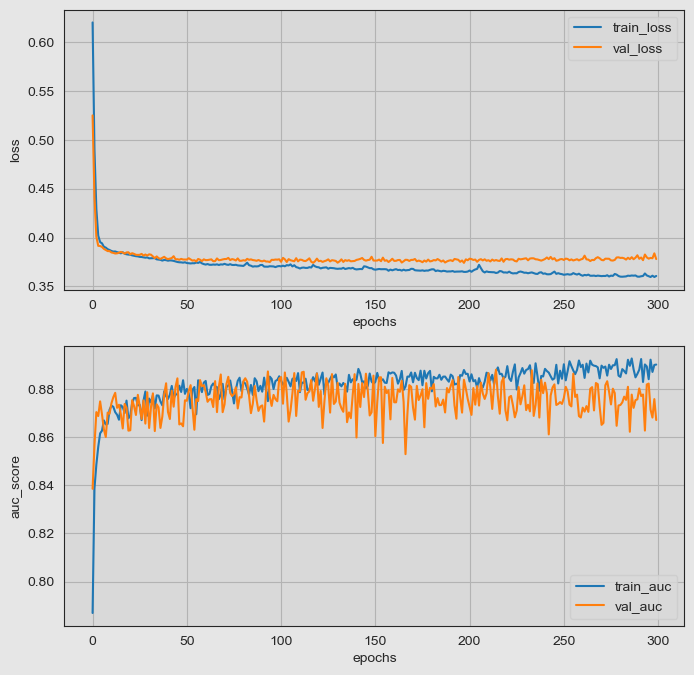

In [71]:
print_losses(best_nn_history)

Как видно из графиков, примерно с 100-й эпохи модель начинает переобучаться

### Вывод по обучению моделей:  

Были рассмотрены три вида моделей:  
- Случайный лес,  
- Градиентный бустинг,  
- Полносвязанная нейросеть.  

После подбора гиперпараметров были достигнуты следующие значения метрики ROC-AUC:  
- Случайный лес - 0.79,  
- Градиентный бустинг - 0.794,  
- Полносвязанная нейросеть - 0.89  

Для дальнейшего тестирования была выбрана модель полносвязанной нейросети со следуюшей архитектурой:  
- слои: 256 -> 1024 -> 256 -> 1;
- функция активации: ELU;  
- BatchNorm и Dropout не использовались.  

Для подготовки данных использовался StandardScaler для шкалирования числовых признаков, OneHotEncoder для кодирования категориальных признаков. 

## Тестирование модели

Напишем функцию для тестирования модели

In [72]:
def test_nn_model(model, valid_loader):
    model.eval()

    num_batch = 0
    running_auc = 0
    running_accuracy = 0
    predict_value = []
    target_value = []

    for inputs, targets in valid_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

        num_batch += 1
        running_auc += roc_auc_score(targets.cpu().detach().numpy(), 
                      (F.sigmoid(outputs.flatten().cpu().detach())).numpy())
        
        running_accuracy += accuracy_score(targets.cpu().detach().numpy(), 
                      (F.sigmoid(outputs.flatten().cpu().detach()) > 0.5).numpy().astype('int'))
        
        predict_value += list((F.sigmoid(outputs.flatten().cpu().detach()) > 0.5).numpy().astype('int'))
        target_value += list(targets.cpu().detach().numpy())
        
    cls_repo = classification_report(target_value, predict_value)
    tn, fp, fn, tp = confusion_matrix(target_value, predict_value).ravel()
    conf_matrix = pd.DataFrame([[tp, fp], [fn, tn]],
                               columns=['Actually 1', 'Actually 0'],
                               index=['Predicted 1', 'Predicted 0'])
    val_auc = running_auc / num_batch
    val_acc = running_accuracy / num_batch

    print('Матрица ошибок на тестовой выборке:')
    print(conf_matrix, '\n')
    print('Classification report:')
    print(cls_repo, '\n')
    print(f'ROC-AUC на тестовой выборке = {val_auc}')
    print(f'Accuracy на тестовой выборке = {val_acc}')
    return val_auc, val_acc

Напишем функцию для визуализации наиболее важных признаков для модели

In [73]:
def get_importance_features(model, X_train, n_sample=None):
    
    names = X_train.columns
    est_features = shap.DeepExplainer(model, 
                                      torch.Tensor(X_train.values).to(DEVICE))
    
    if n_sample:
        X_sample = X_train.sample(n_sample)
    else:
        X_sample = X_train

    shap_values = est_features.shap_values(torch.Tensor(X_sample.values).to(DEVICE))

    shap.summary_plot(shap_values, features=X_sample, feature_names=names)
    
    return shap_values

Протестируем лучшую модель

In [74]:
test_auc, test_acc = test_nn_model(best_nn_model, test_loader)

Матрица ошибок на тестовой выборке:
             Actually 1  Actually 0
Predicted 1         270         110
Predicted 0         197        1184 

Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      1294
         1.0       0.71      0.58      0.64       467

    accuracy                           0.83      1761
   macro avg       0.78      0.75      0.76      1761
weighted avg       0.82      0.83      0.82      1761
 

ROC-AUC на тестовой выборке = 0.8650090528624607
Accuracy на тестовой выборке = 0.8247595268777614


На тестовой выборке достигнуто значение метрики ROC-AUC = 0.865.

Посмотрим расположение признаков по важности для лучшей модели

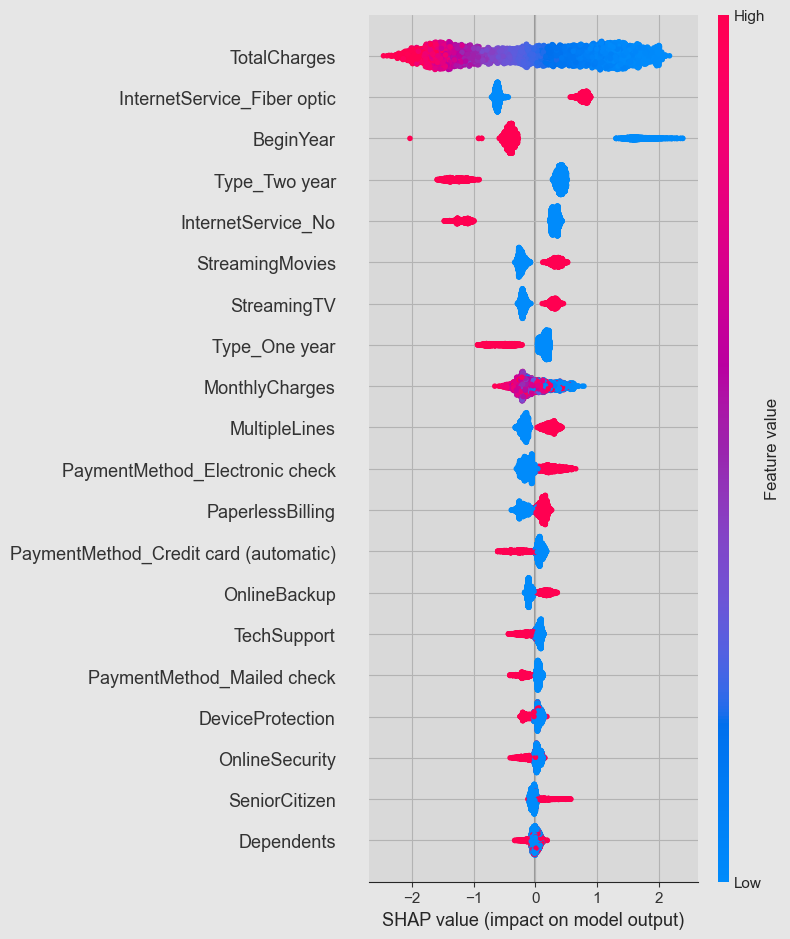

In [75]:
shap_values_nn_model = get_importance_features(best_nn_model,
                                               X_train_encode_n_scal)

Выводы по тестированию:  
- Достигнутое значение метрики ROC-AUC на тестовой выборке составляет 0.883;
- Точность предсказания 82%;  
- Для класса ушедших клиентов значение точности и полноты составляет 0.68 и 0.61 соответственно;  
- Топ три признака по важности для модели:  
    - TotalCharges (Общие расходы клиента);
    - InternetService_Fiber_optic (Наличие оптаволокна);  
    - Type_Two_year (оплата на два года вперед);  
- Наиболее опасные клиенты имеют следующий портрет (согласно важности признаков):  
    - Низкий уровень общих расходов;  
    - Наличие оптоволокна;
    - Оплата помесячная.

## Общий вывод

В ходе проетка была проведена выгрузка датасета с бащы данных SQL. Был проведен первичный анализ и оценка данных. Был сформирован итоговый датасет и сгенерированы новые признаки для обучения моделей.   
Для шкалирования числовых признаков использовался StandardScaler. Для кодирвания категориальных признаков использовался OneHotEncoder.  

Были рассмотрены три вида моделей:  
- Случайный лес,  
- Градиентный бустинг,  
- Полносвязанная нейросеть.  

После подбора гиперпараметров были достигнуты следующие значения метрики ROC-AUC:  
- Случайный лес - 0.79,  
- Градиентный бустинг - 0.794,  
- Полносвязанная нейросеть - 0.89  

Для итогового тестирования была выбрана модель полносвязанной нейросети со следуюшей архитектурой:  
- слои: 256 -> 1024 -> 256 -> 1;
- функция активации: ELU;  
- BatchNorm и Dropout не использовались. 

Выводы по тестированию:  
- Достигнутое значение метрики ROC-AUC на тестовой выборке составляет 0.883;
- Точность предсказания 82%;  
- Для класса ушедших клиентов значение точности и полноты составляет 0.68 и 0.61 соответственно;  
- Топ три признака по важности для модели:  
    - TotalCharges (Общие расходы клиента);
    - InternetService_Fiber_optic (Наличие оптаволокна);  
    - Type_Two_year (оплата на два года вперед);  
- Наиболее опасные клиенты имеют следующий портрет (согласно важности признаков):  
    - Низкий уровень общих расходов;  
    - Наличие оптоволокна;
    - Оплата помесячная.